# Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as L
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

2.1.0


Using TensorFlow backend.


# Load data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
start_token = " " # so that the network knows that we're generating a first token

# this is the token for padding,
# we will add fake pad token at the end of names 
# to make them of equal size for further batching
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [3]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


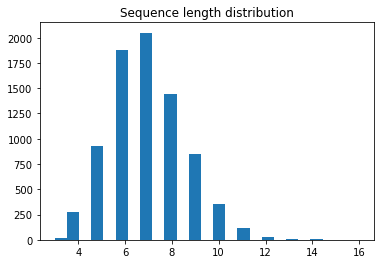

In [4]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

# Text processing

First we need to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [5]:
tokens = {c for name in names for c in name}# all unique characters go here, padding included!

tokens = list(tokens) + ['#']
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

n_tokens: 56


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign `token_to_id`

In [8]:
token_to_id = {token:i for i, token in enumerate(tokens)} #dictionary of {symbol -> its  index in tokens}

assert len(tokens) == len(token_to_id)

In [9]:
def to_matrix(names, max_len=None, pad=token_to_id[pad_token], dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [10]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[22 12  7 44 48 44 45 20 55]
 [22 36 20 23 13 54 55 55 55]
 [22  8 13 15 28 28 15 45 55]
 [22 36 15 23 25 44 10 10 45]]


# Defining a recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=600>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme based on h_t+1

We will generate names character by character starting with `start_token`:

<img src="./char-nn.png" width=600>

In [ ]:
rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

In [17]:
class rnn_one_step(L.Layer):

    def __init__(self):
        super(rnn_one_step, self).__init__()
        self.Embed = L.Embedding(n_tokens, embedding_size)
        self.Dense_1 = L.Dense(rnn_num_units, activation='tanh')
        self.Dense_2 = L.Dense(n_tokens, activation='softmax')

    def call(self, x_t, h_t):
        x_t_emb = self.Embed(tf.reshape(x_t, [-1, 1]))[:, 0]
        x_and_h = L.concatenate([x_t_emb, h_t])
        h_next = self.Dense_1(x_and_h)
        output_probas = self.Dense_2(h_next)
        return output_probas, h_next


# RNN: loop

Once `rnn_one_step` is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most length-16 for now, so we can simply iterate over them in a for loop.


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [19]:
rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

In [27]:
class RNN(tf.keras.Model):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = rnn_one_step()        
    
    def call(self, inputs):
        self.h_prev = tf.zeros([inputs.shape[0], 64])
        predicted_probas = []
        for t in range(inputs.shape[1]):
            x_t = inputs[:, t]  
            probas_next, h_next = self.rnn(x_t, self.h_prev)
            self.h_prev = h_next
            predicted_probas.append(probas_next)
        predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])
        predicted_probas = predicted_probas[:, :-1, :]
        predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])
        return predictions_matrix

In [28]:
rnn = RNN()

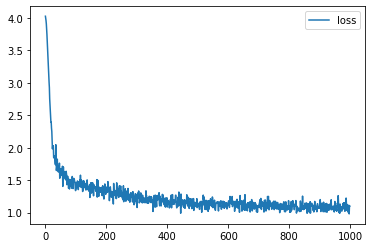

In [29]:
from IPython.display import clear_output
from random import sample


batch_size = 32
history = []

cce = tf.keras.losses.CategoricalCrossentropy(
                                  from_logits=False, 
                                  label_smoothing=0,
                                  name='categorical_crossentropy')

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    with tf.GradientTape() as tape:
        predictions_matrix = rnn(batch)
        answers_matrix = tf.one_hot(tf.reshape(batch[:, 1:], [-1]), 
                                n_tokens)
        loss = cce(answers_matrix, predictions_matrix)
        grads = tape.gradient(loss, rnn.trainable_weights)
        optimizer.apply_gradients(zip(grads, rnn.trainable_weights))
        
    history.append(loss)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()
        
assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

# RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` layer we have written above.

In [48]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable

    x_sequence = [token_to_id[token] for token in seed_phrase]
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
        _, h_t = rnn.rnn(tf.Variable([ix]), h_t)
        
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs, h_t = rnn.rnn(tf.Variable([x_sequence[-1]]), h_t)
        x_sequence.append(np.random.choice(n_tokens, p=tf.keras.backend.eval(x_probs[0])))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [49]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Eheae
 Ranele
 Dary
 TaMenin
 Elenanle
 Gasgalg
 Mosbarde
 Cranledsa
 Helk
 Acqaysu


In [42]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

 Trumpeet
 Trumpil
 Trump
 Trumpa
 Trumpy
 Trumpa
 Trumpee
 Trumpaae
 Trumpic
 Trumpda


We've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data we can try it on:

* Novels/poems/songs
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* IKEA catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* MAX_LENGTH should be adjusted for longer datasets. 
* More complex tasks require larger RNN architecture, so we may want to try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

RNN loop that we implemented for training can be replaced with single Keras instruction: [tf.keras.layers.SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). This layer loops over `keras.layers.SimpleRNNCell` which, performs one step rnn.
This interface allows for dynamic sequence length and comes with some pre-implemented architectures.

Note that we never used MAX_LENGTH in the code above: TF will iterate over however many time-steps you gave it.